This notebook is to use Tensorflow to build Convolutional Neural Networks for facial expression recogonition (Kaggle challenge: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). 

Some useful reference:

1.Official instruction: https://www.tensorflow.org/tutorials/mnist/pros/

2.Official network training instruction: https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py

3.One detailed CNN model building notebook
https://www.kaggle.com/kakauandme/digit-recognizer/tensorflow-deep-nn/discussion

4.Official API: https://www.tensorflow.org/tutorials/mnist/pros/

## Input library

In [0]:
import pandas as pd 
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [0]:
data = pd.read_csv("input.csv")

In [20]:
#check the number of images and each image data variable
data.shape

(1320, 3)

In [21]:
data.head()

,emotion,pixels,Usage
0,1,36 64 90 40 46 57 112 144 154 150 121 78 67 59...,Training
1,2,96 96 95 93 93 93 87 64 56 50 43 39 37 36 65 1...,Training
2,2,254 254 252 252 252 252 252 252 252 250 232 13...,Training
3,1,140 125 90 88 73 53 50 55 56 72 60 73 63 94 99...,Training
4,1,220 221 220 220 220 220 220 220 220 220 221 15...,Training


In [22]:
np.unique(data["Usage"].values.ravel())

array(['PrivateTest', 'PublicTest', 'Training'], dtype=object)

In [50]:
print 'The number of training data set is %d'%(len(data[data.Usage == "Training"]))

The number of training data set is 844


In [0]:
pixels_values = data.pixels.str.split(" ").tolist()

In [0]:
pixels_values = pd.DataFrame(pixels_values, dtype=int)

In [0]:
images = pixels_values.values

In [0]:
images = images.astype(np.float)

In [55]:
images

array([[ 36.,  64.,  90., ...,  39.,  39.,  39.],
       [ 96.,  96.,  95., ...,  30.,  26.,  28.],
       [254., 254., 252., ..., 250., 251., 254.],
       ...,
       [ 61.,  61.,  62., ...,  62.,  53.,  59.],
       [ 31.,  34.,  40., ..., 100., 100., 100.],
       [ 14.,  14.,  14., ...,  31.,  31.,  32.]])

In [0]:
#Define a function to show image through 48*48 pixels
def show(img):
    show_image = img.reshape(48,48)
    
    #plt.imshow(show_image, cmap=cm.binary)
    plt.imshow(show_image, cmap='gray')

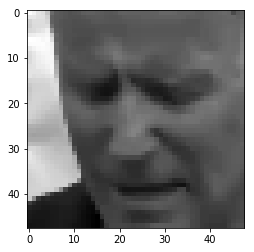

In [57]:
#show one image
show(images[7])

## Image data pre-processing

Data pre-processing strategy is based on this paper: http://deeplearning.net/wp-content/uploads/2013/03/dlsvm.pdf

In [0]:
images = images - images.mean(axis=1).reshape(-1,1)

In [0]:
images = np.multiply(images,100.0/255.0)

In [0]:
each_pixel_mean = images.mean(axis=0)

In [0]:
each_pixel_std = np.std(images, axis=0)

In [0]:
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)

In [63]:
images.shape

(1320, 2304)

In [64]:
image_pixels = images.shape[1]
print 'Flat pixel values is %d'%(image_pixels)

Flat pixel values is 2304


In [0]:
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)

In [66]:
image_width

48

In [0]:
labels_flat = data["emotion"].values.ravel()

In [0]:
labels_count = np.unique(labels_flat).shape[0]

In [84]:
print 'The number of different facial expressions is %d'%labels_count

The number of different facial expressions is 3


In [0]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [0]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [87]:
labels[0]

array([0, 1, 0], dtype=uint8)

In [0]:
train_mask = (data["Usage"] == "Training")
valid_mask = (data["Usage"] == "PublicTest")

train_images = images[train_mask]
train_labels = labels[train_mask]

validation_images = images[valid_mask]
validation_labels = labels[valid_mask]


In [94]:
print 'The number of final training data: %d'%(train_images.shape[0])

The number of final training data: 844


## Build Tensorflow CNN model

In [0]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [0]:
# convolution
def conv2d(x, W, padd):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding=padd)

In [0]:
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_pixels])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [0]:
# first convolutional layer 64
W_conv1 = weight_variable([5, 5, 1, 64])
b_conv1 = bias_variable([64])

# (27000, 2304) => (27000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(27000,48,48,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1, "SAME") + b_conv1)
#print (h_conv1.get_shape()) # => (27000,48,48,64)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (27000,24,24,1)
h_norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

In [0]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 64, 128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_norm1, W_conv2, "SAME") + b_conv2)
#print (h_conv2.get_shape()) # => (27000,24,24,128)

h_norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

h_pool2 = max_pool_2x2(h_norm2)

In [0]:
# local layer weight initialization
def local_weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.04)
    return tf.Variable(initial)

def local_bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

In [0]:
# densely connected layer local 3
W_fc1 = local_weight_variable([12 * 12 * 128, 3072])
b_fc1 = local_bias_variable([3072])

# (27000, 12, 12, 128) => (27000, 12 * 12 * 128)
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 128])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (27000, 1024)

In [0]:
# densely connected layer local 4
W_fc2 = local_weight_variable([3072, 1536])
b_fc2 = local_bias_variable([1536])

# (40000, 7, 7, 64) => (40000, 3136)
h_fc2_flat = tf.reshape(h_fc1, [-1, 3072])

h_fc2 = tf.nn.relu(tf.matmul(h_fc2_flat, W_fc2) + b_fc2)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [104]:
# dropout
keep_prob = tf.placeholder('float')
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

W1126 04:07:16.487796 140033929193344 deprecation.py:506] From <ipython-input-104-b59851c63ba8>:2: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# readout layer for deep net
W_fc3 = weight_variable([1536, labels_count])
b_fc3 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

#print (y.get_shape()) # => (40000, 10)

In [0]:
# settings
LEARNING_RATE = 1e-4

In [0]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [0]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [0]:
# set to 3000 iterations 
TRAINING_ITERATIONS = 3000
    
DROPOUT = 0.5
BATCH_SIZE = 50

In [0]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [111]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

W1126 04:07:29.606332 140033929193344 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/util/tf_should_use.py:198: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [0]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

In [113]:
for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i and display_step<100:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.68 / 0.56 for step 0
training_accuracy / validation_accuracy => 0.50 / 0.56 for step 1
training_accuracy / validation_accuracy => 0.60 / 0.56 for step 2
training_accuracy / validation_accuracy => 0.54 / 0.56 for step 3
training_accuracy / validation_accuracy => 0.46 / 0.56 for step 4
training_accuracy / validation_accuracy => 0.66 / 0.56 for step 5
training_accuracy / validation_accuracy => 0.52 / 0.56 for step 6
training_accuracy / validation_accuracy => 0.48 / 0.56 for step 7
training_accuracy / validation_accuracy => 0.58 / 0.56 for step 8
training_accuracy / validation_accuracy => 0.62 / 0.56 for step 9
training_accuracy / validation_accuracy => 0.52 / 0.56 for step 10
training_accuracy / validation_accuracy => 0.50 / 0.56 for step 20
training_accuracy / validation_accuracy => 0.56 / 0.56 for step 30
training_accuracy / validation_accuracy => 0.54 / 0.56 for step 40
training_accuracy / validation_accuracy => 0.50 / 0.56 for step 50
train

## Results analysis visualizatioin

In [0]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

validation_accuracy => 0.5568


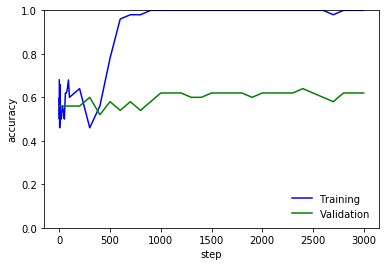

In [115]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.0, ymin = 0.0)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [116]:
saver = tf.train.Saver(tf.all_variables())

W1126 05:36:48.387239 140033929193344 deprecation.py:323] From <ipython-input-116-ebc2fe8edd68>:1: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


In [117]:
saver.save(sess, 'my-model1', global_step=0)

'my-model1-0'

In [0]:
# read test data from CSV file 
test_data = data[data.Usage == "PrivateTest"]

In [119]:
test_data.head()

,emotion,pixels,Usage
1108,2,73 81 96 103 110 114 117 119 122 122 125 128 1...,PrivateTest
1109,0,87 94 96 79 70 58 41 30 30 35 45 67 115 128 14...,PrivateTest
1110,1,93 36 31 44 66 88 93 93 88 75 60 43 39 44 49 5...,PrivateTest
1111,2,17 28 58 94 120 148 168 178 182 182 180 175 17...,PrivateTest
1112,1,60 59 60 58 55 38 16 9 6 6 9 11 14 16 9 4 8 12...,PrivateTest


In [120]:
len(test_data)

212

In [0]:
test_pixels_values = test_data.pixels.str.split(" ").tolist()

In [0]:
test_pixels_values = pd.DataFrame(test_pixels_values, dtype=int)

In [0]:
test_images = test_pixels_values.values

In [0]:
test_images = test_images.astype(np.float)

In [0]:
test_images = test_images - test_images.mean(axis=1).reshape(-1,1)
test_images = np.multiply(test_images,100.0/255.0)

In [0]:
test_images = np.divide(np.subtract(test_images,each_pixel_mean), each_pixel_std)

In [127]:
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])

test_images(212,2304)


In [128]:
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))


predicted_lables(212)


In [129]:
predicted_lables

array([1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 2., 1., 1., 2., 1.,
       2., 1., 1., 1., 1., 2., 1., 2., 1., 0., 2., 2., 1., 2., 1., 1., 1.,
       2., 1., 0., 0., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 0., 1., 0.,
       2., 1., 1., 1., 2., 2., 1., 1., 2., 0., 1., 0., 2., 2., 1., 1., 1.,
       1., 1., 0., 2., 2., 1., 1., 1., 0., 0., 2., 0., 0., 1., 2., 2., 1.,
       2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 0., 2., 2., 1., 1.,
       1., 0., 1., 0., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
       1., 2., 1., 1., 1., 0., 1., 2., 1., 2., 2., 2., 1., 2., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1.,
       0., 2., 2., 0., 1., 0., 1., 1., 0., 2., 1., 1., 0., 1., 2., 0., 1.,
       1., 1., 1., 0., 2., 2., 0., 1., 0., 1., 0., 1., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [130]:
test_data.emotion.values

array([2, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1,
       2, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1,
       2, 2, 1, 0, 1, 1, 2, 0, 2, 2, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2,
       2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2,
       1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0,
       1, 2, 2, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0])

In [131]:
accuracy_score(test_data.emotion.values, predicted_lables)

0.5518867924528302

In [132]:
confusion_matrix(test_data.emotion.values, predicted_lables)

array([[14, 22,  4],
       [18, 73, 15],
       [ 8, 28, 30]])

In [0]:
cnf_matrix = confusion_matrix(test_data.emotion.values, predicted_lables)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Confusion matrix, without normalization
[[14 22  4]
 [18 73 15]
 [ 8 28 30]]


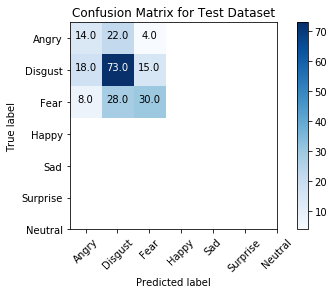

In [136]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion Matrix for Test Dataset')

plt.show()